# Import

In [2]:
import os
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import scipy.fft as fft
from sklearn.neighbors import KNeighborsClassifier as Knn

# Пути
Задать путь до обучающего каталога, и тестового 

In [3]:
path_to_train = '.\\orl_faces'
path_to_test = '.\\orl_faces'
path_to_test_masks = '.\\orl_faces_with_mask'
path_to_test_deind = '.\\orl_faces_high_cloaked'

# Методы

### Histogram

In [4]:
def histogram(img, histSize, use_plot=False):
    histRange = (0, 256)
    accumulate = False
    if use_plot:
        hist, bars, _ = plt.hist(img.ravel(), histSize, histRange, rwidth=0.75)
    else:
        hist = cv.calcHist([img], [0], None, [histSize], histRange, accumulate=accumulate).ravel()
    return hist

### DFT

In [13]:
def dft(img, p, use_plot=False):
    f = np.fft.fft2(img, (p, p))
    fshift = np.fft.fftshift(f)
    # magnitude_spectrum = 20 * np.log(np.abs(fshift))
    magnitude_spectrum = np.abs(fshift)
    # magnitude_spectrum = cv.normalize(np.abs(fshift), None, 0, 255, cv.NORM_MINMAX)
    if use_plot:
        plt.imshow(magnitude_spectrum, cmap='gray')
    return magnitude_spectrum.ravel()


def dft1(img, p, use_plot=False):
    f = np.fft.fft2(img, (p, p))
    f[0, 0] = 0
    fshift = np.fft.fftshift(f)
    # magnitude_spectrum = 20 * np.log(np.abs(fshift))
    magnitude_spectrum = np.abs(fshift)
    # magnitude_spectrum = cv.normalize(np.abs(fshift), None, 0, 255, cv.NORM_MINMAX)
    # height_mid = magnitude_spectrum.shape[0] // 2
    # width_mid = magnitude_spectrum.shape[1] // 2
    # p_mid = p // 2
    # print(magnitude_spectrum[height_mid , width_mid - 1])
    if use_plot:
        plt.imshow(magnitude_spectrum[p//2:,:], cmap='gray')
    return magnitude_spectrum.ravel()

### DCT

In [6]:
#max p = 50
def dct(img, p, use_plot=False):
    spectrum = fft.dct(fft.dct(img.T, n=p, type=2, norm='ortho').T, n=p, type=2, norm='ortho')
    spectrum[0, 0] = 0
    # spectrum = 20 * np.log(np.abs(spectrum))
    # spectrum = np.abs(spectrum)
    spectrum = cv.normalize(spectrum, None, 0, (img.shape[0]*img.shape[1])**(1/2), cv.NORM_MINMAX)
    spectrum_vector = [spectrum[i,j] for i in range(p) for j in range(0, p-i)]
    if use_plot:
        plt.imshow(spectrum, cmap='gray')
    return np.array(spectrum_vector)

### Scale

In [7]:
# максимум scale
def scale(img, scale_height, use_plot=False):
    scale_width = int(scale_height * (img.shape[1] / img.shape[0]))
    scaled_img = cv.resize(img, (scale_width, scale_height), interpolation=cv.INTER_LINEAR)
    if use_plot:
        plt.imshow(scaled_img, cmap='gray')
    return scaled_img.ravel()

### Grad

In [8]:
# h = 5
def grad(img, h, use_plot=False):
    d = []
    for i in range(h, img.shape[0]-h):
        res = np.sum(img[i:i+h, :].astype(np.int16) - img[i-h:i, :].astype(np.int16))
        d.append(res)
    d = np.array(d)
    if use_plot:
        plt.plot(d)
        plt.grid()
    return d

# Classifier

In [8]:
class Classifier(Knn):
    def __init__(self, n_neighbours, method, num, param):
        self.method = method
        self.num = num
        self.param = param
        super().__init__(n_neighbours)

    def set_num_photos(self, num):
        self.num = num

    def set_param(self, param):
        self.param = param

    def fit(self, path_to_db):
        dirs = os.listdir(path_to_db)
        X = []
        y = []
        for dir in dirs:
            label = int(dir[1:])
            photos = os.listdir(os.path.join(path_to_db, dir))
            for photo_name in photos[:self.num]:
                path_photo = os.path.join(path_to_db, dir, photo_name)
                photo = cv.imread(path_photo, 0)
                vec = self.method(photo, self.param)
                X.append(vec)
                y.append(label)
        X = np.array(X)
        y = np.array(y)
        # print(X)
        # print(y)
        super().fit(X, y)
        return self

    def predict_one_train(self, path_to_db, man_number=None):
        """
        predict_one_train(self, path_to_db, man_number=None)

        Предсказывает класс последнего изображения из тренировочных. Если задан man_number,
        то работает для конкретного класса, иначе для всех.
        """

        dirs = os.listdir(path_to_db)
        X = []
        y = []
        if man_number is None:
            for dir in dirs:
                label = int(dir[1:])
                photos = os.listdir(os.path.join(path_to_db, dir))
                photo_name = photos[self.num-1]
                path_photo = os.path.join(path_to_db, dir, photo_name)
                photo = cv.imread(path_photo, 0)
                vec = self.method(photo, self.param)
                X.append(vec)
                y.append(label)
        else:
            dir = dirs[man_number-1]
            label = int(dir[1:])
            photos = os.listdir(os.path.join(path_to_db, dir))
            photo_name = photos[self.num - 1]
            path_photo = os.path.join(path_to_db, dir, photo_name)
            photo = cv.imread(path_photo, 0)
            vec = self.method(photo, self.param)
            X.append(vec)
            y.append(label)
        X = np.array(X)
        y = np.array(y)
        return self.predict(X), y

    def predict_all_train(self, path_to_db, man_number=None):
        """
        predict_all_train(self, path_to_db, man_number=None)

        Предсказывает класс всех изображений из тренировочных. Если задан man_number,
        то работает для конкретного класса, иначе для всех.
        """

        dirs = os.listdir(path_to_db)
        X = []
        y = []
        if man_number is None:
            for dir in dirs:
                label = int(dir[1:])
                photos = os.listdir(os.path.join(path_to_db, dir))
                for photo_name in photos[:self.num]:
                    path_photo = os.path.join(path_to_db, dir, photo_name)
                    photo = cv.imread(path_photo, 0)
                    vec = self.method(photo, self.param)
                    X.append(vec)
                    y.append(label)
        else:
            dir = dirs[man_number-1]
            label = int(dir[1:])
            photos = os.listdir(os.path.join(path_to_db, dir))
            for photo_name in photos[:self.num]:
                path_photo = os.path.join(path_to_db, dir, photo_name)
                photo = cv.imread(path_photo, 0)
                vec = self.method(photo, self.param)
                X.append(vec)
                y.append(label)
        X = np.array(X)
        y = np.array(y)
        return self.predict(X), y

    def predict_one_test(self, path_to_db, man_number=None):
        """
        predict_one_test(self, path_to_db, man_number=None)

        Предсказывает класс первоого изображения из тестовых. Если задан man_number,
        то работает для конкретного класса, иначе для всех.
        """

        dirs = os.listdir(path_to_db)
        X = []
        y = []
        if man_number is None:
            for dir in dirs:
                label = int(dir[1:])
                photos = os.listdir(os.path.join(path_to_db, dir))
                photo_name = photos[self.num]
                path_photo = os.path.join(path_to_db, dir, photo_name)
                photo = cv.imread(path_photo, 0)
                vec = self.method(photo, self.param)
                X.append(vec)
                y.append(label)
        else:
            dir = dirs[man_number-1]
            label = int(dir[1:])
            photos = os.listdir(os.path.join(path_to_db, dir))
            photo_name = photos[self.num]
            path_photo = os.path.join(path_to_db, dir, photo_name)
            photo = cv.imread(path_photo, 0)
            vec = self.method(photo, self.param)
            X.append(vec)
            y.append(label)
        X = np.array(X)
        y = np.array(y)
        return self.predict(X), y

    def predict_all_test(self, path_to_db, changed_db=False, man_number=None):
        """
        predict_all_test(self, path_to_db, changed_db=False, man_number=None)

        Предсказывает класс всех изображений из тестовых. Если задан man_number,
        то работает для конкретного класса, иначе для всех. Если задан changed_db,
        то работает для всех изображений.
        """

        dirs = os.listdir(path_to_db)
        X = []
        y = []
        num = 0 if changed_db else self.num
        if man_number is None:
            for dir in dirs:
                label = int(dir[1:])
                photos = os.listdir(os.path.join(path_to_db, dir))
                for photo_name in photos[num:]:
                    path_photo = os.path.join(path_to_db, dir, photo_name)
                    photo = cv.imread(path_photo, 0)
                    vec = self.method(photo, self.param)
                    X.append(vec)
                    y.append(label)
        else:
            dir = dirs[man_number-1]
            label = int(dir[1:])
            photos = os.listdir(os.path.join(path_to_db, dir))
            for photo_name in photos[num:]:
                path_photo = os.path.join(path_to_db, dir, photo_name)
                photo = cv.imread(path_photo, 0)
                vec = self.method(photo, self.param)
                X.append(vec)
                y.append(label)
        X = np.array(X)
        y = np.array(y)
        return self.predict(X), y

    def draw_predict(self, path_to_db, man, num_photo, path_to_train=None):
        """
        draw_predict(self, path_to_db, man, num_photo)

        Возвращает исходное и спрогнозированное изображение.

        """
        path_to_train = path_to_db if path_to_train is None else path_to_train
        dirs = os.listdir(path_to_db)
        X = []
        dir = dirs[man - 1]
        class_name = int(dir[1:])
        photos = os.listdir(os.path.join(path_to_db, dir))
        photo_name = photos[num_photo]
        path_photo = os.path.join(path_to_db, dir, photo_name)
        photo = cv.imread(path_photo, 0)
        vec = self.method(photo, self.param)
        X.append(vec)

        nearest = self.kneighbors(X, return_distance=False)
        nearest = nearest[0, 0]
        pred_man = nearest // self.num
        pred_num_photo = nearest % self.num
        dirs = os.listdir(path_to_train)
        pred_dir = dirs[pred_man]
        pred_class_name = int(pred_dir[1:])
        photos = os.listdir(os.path.join(path_to_train, pred_dir))
        pred_photo_name = photos[pred_num_photo]
        pred_path_photo = os.path.join(path_to_train, pred_dir, pred_photo_name)
        pred_photo = cv.imread(pred_path_photo, 0)

        plt.figure(facecolor='white')
        plt.subplot(121)
        plt.title(f"Original, class {class_name}")
        plt.imshow(photo, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.subplot(122)
        plt.title(f"Predicted, class {pred_class_name}")
        plt.xticks([])
        plt.yticks([])
        plt.imshow(pred_photo, cmap='gray')

    def return_pred_picture(self, path_to_db, man, num_photo, path_to_train=None):
        """
        return_pred_picture(self, path_to_db, man, num_photo)

        Возвращает спрогнозированное изображение.
        
        """
        path_to_train = path_to_db if path_to_train is None else path_to_train
        dirs = os.listdir(path_to_db)
        X = []
        dir = dirs[man - 1]
        photos = os.listdir(os.path.join(path_to_db, dir))
        photo_name = photos[num_photo]
        path_photo = os.path.join(path_to_db, dir, photo_name)
        photo = cv.imread(path_photo, 0)
        vec = self.method(photo, self.param)
        X.append(vec)

        nearest = self.kneighbors(X, return_distance=False)
        nearest = nearest[0, 0]
        pred_man = nearest // self.num
        pred_num_photo = nearest % self.num
        dirs = os.listdir(path_to_train)
        pred_dir = dirs[pred_man]
        pred_class_name = int(pred_dir[1:])
        photos = os.listdir(os.path.join(path_to_train, pred_dir))
        pred_photo_name = photos[pred_num_photo]
        pred_path_photo = os.path.join(path_to_train, pred_dir, pred_photo_name)
        pred_photo = cv.imread(pred_path_photo, 0)
        return pred_photo

    def return_pred_picture_info(self, path_to_db, man, num_photo, path_to_train=None):
        """
        return_pred_picture(self, path_to_db, man, num_photo)

        Возвращает информацию о спрогнозированном изображении
        
        """
        path_to_train = path_to_db if path_to_train is None else path_to_train
        dirs = os.listdir(path_to_db)
        X = []
        dir = dirs[man - 1]
        photos = os.listdir(os.path.join(path_to_db, dir))
        photo_name = photos[num_photo]
        path_photo = os.path.join(path_to_db, dir, photo_name)
        photo = cv.imread(path_photo, 0)
        vec = self.method(photo, self.param)
        X.append(vec)

        nearest = self.kneighbors(X, return_distance=False)
        nearest = nearest[0, 0]
        pred_man = nearest // self.num
        pred_num_photo = nearest % self.num
        dirs = os.listdir(path_to_train)
        pred_dir = dirs[pred_man]
        photos = os.listdir(os.path.join(path_to_train, pred_dir))
        pred_photo_name = photos[pred_num_photo]
        return pred_dir, pred_photo_name

    def return_pred_class(self, path_to_db, man, num_photo):
        """
        return_pred_class(self, path_to_db, man, num_photo)

        Возвращает спрогнозированный класс и исходный класс изображения.

        """
        dirs = os.listdir(path_to_db)
        X = []
        dir = dirs[man - 1]
        class_name = int(dir[1:])
        photos = os.listdir(os.path.join(path_to_db, dir))
        photo_name = photos[num_photo]
        path_photo = os.path.join(path_to_db, dir, photo_name)
        photo = cv.imread(path_photo, 0)
        vec = self.method(photo, self.param)
        X.append(vec)
        return self.predict(X)[0], class_name


    def count_error_test(self, path_to_db, man_number=None):
        dirs = os.listdir(path_to_db)
        X = []
        y = []
        if man_number is None:
            for i in range(1, 41):
                y += [i] * (10-self.num)
        else:
            y = man_number * (10-self.num)
        y = np.array(y)

## Получение картинки по номеру класса и порядковому номеру

In [12]:
def get_image(path_to_db, man, num_photo ):
    dirs = os.listdir(path_to_db)
    dir = dirs[man - 1]
    photos = os.listdir(os.path.join(path_to_db, dir))
    photo_name = photos[num_photo]
    path_photo = os.path.join(path_to_db, dir, photo_name)
    photo = cv.imread(path_photo, 0)
    return photo

# Вывод методов

In [11]:
def show_methods(path_to_db):
    dirs = os.listdir(path_to_db)
    dir = dirs[0]
    photos = os.listdir(os.path.join(path_to_db, dir))
    photo = photos[0]
    photo_path = os.path.join(path_to_db, dir, photo)
    img = cv.imread(photo_path, 0)

    plt.figure(figsize=(10.5, 6))

    plt.subplot(231)
    plt.title('Original')
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(232)
    plt.title("Scale, height = 15")
    scale(img, 15, use_plot=True)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(233)
    plt.title("Histogram, histSize = 16")
    histogram(img, 16, use_plot=True)

    plt.subplot(234)
    plt.title('DFT, p = 20')
    dft1(img, 20, use_plot=True)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(235)
    plt.title('DCT, p = 10')
    dct(img, 10, use_plot=True)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(236)
    plt.title('Grad, Hw = 5')
    grad(img, 5, use_plot=True)
    plt.grid()
    plt.show()

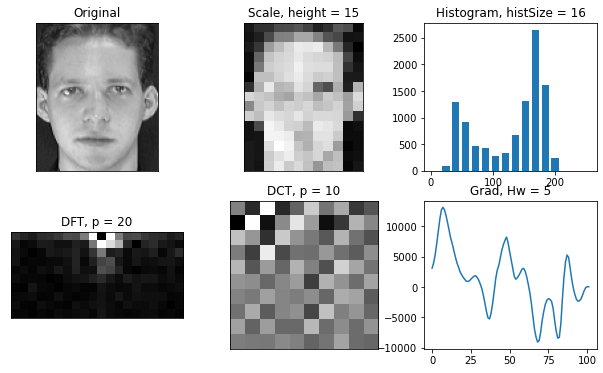

In [14]:
show_methods(path_to_train)

# Оптимальные параметры

In [13]:
def count_error(pred, real):
    return np.sum(pred == real) / real.shape[0]

In [14]:
def create_table_for_parametrs(path_to_db_train, path_to_db_test, method, params, param_shift):
    num_photos = range(9)
    num_photo_shift = 1
    data = np.zeros((len(params), 9))
    classifier = Classifier(1, method, 1, 10)
    for param in params:
        for num_photo in num_photos:
            classifier.set_num_photos(num_photo + num_photo_shift)
            classifier.set_param(param + param_shift)
            classifier.fit(path_to_db_train)
            pred, real = classifier.predict_all_test(path_to_db_test)
            data[param, num_photo] = count_error(pred, real)
            print(f'Finished for {num_photo + num_photo_shift} picture, {param + param_shift} param')
    return data

### Гистограмма

In [ ]:
data_hist = create_table_for_parametrs(path_to_train, path_to_test, histogram, range(26), 5)

### DFT

In [62]:
data_dft = create_table_for_parametrs(path_to_train, path_to_test, dft, range(26), 10)
np.savetxt('dft1.csv', data_dft, delimiter=';', fmt='%.2f')

Finished for 1 picture, 10 param
Finished for 2 picture, 10 param
Finished for 3 picture, 10 param
Finished for 4 picture, 10 param
Finished for 5 picture, 10 param
Finished for 6 picture, 10 param
Finished for 7 picture, 10 param
Finished for 8 picture, 10 param
Finished for 9 picture, 10 param
Finished for 1 picture, 11 param
Finished for 2 picture, 11 param
Finished for 3 picture, 11 param
Finished for 4 picture, 11 param
Finished for 5 picture, 11 param
Finished for 6 picture, 11 param
Finished for 7 picture, 11 param
Finished for 8 picture, 11 param
Finished for 9 picture, 11 param
Finished for 1 picture, 12 param
Finished for 2 picture, 12 param
Finished for 3 picture, 12 param
Finished for 4 picture, 12 param
Finished for 5 picture, 12 param
Finished for 6 picture, 12 param
Finished for 7 picture, 12 param
Finished for 8 picture, 12 param
Finished for 9 picture, 12 param
Finished for 1 picture, 13 param
Finished for 2 picture, 13 param
Finished for 3 picture, 13 param
Finished f

### DCT

In [81]:
data_dct = create_table_for_parametrs(path_to_train, path_to_test, dct, range(26), 5)
np.savetxt('dct1.csv', data_dct, delimiter=';', fmt='%.2f')

Finished for 1 picture, 5 param
Finished for 2 picture, 5 param
Finished for 3 picture, 5 param
Finished for 4 picture, 5 param
Finished for 5 picture, 5 param
Finished for 6 picture, 5 param
Finished for 7 picture, 5 param
Finished for 8 picture, 5 param
Finished for 9 picture, 5 param
Finished for 1 picture, 6 param
Finished for 2 picture, 6 param
Finished for 3 picture, 6 param
Finished for 4 picture, 6 param
Finished for 5 picture, 6 param
Finished for 6 picture, 6 param
Finished for 7 picture, 6 param
Finished for 8 picture, 6 param
Finished for 9 picture, 6 param
Finished for 1 picture, 7 param
Finished for 2 picture, 7 param
Finished for 3 picture, 7 param
Finished for 4 picture, 7 param
Finished for 5 picture, 7 param
Finished for 6 picture, 7 param
Finished for 7 picture, 7 param
Finished for 8 picture, 7 param
Finished for 9 picture, 7 param
Finished for 1 picture, 8 param
Finished for 2 picture, 8 param
Finished for 3 picture, 8 param
Finished for 4 picture, 8 param
Finished

### Scale

In [84]:
data_scale = create_table_for_parametrs(path_to_train, path_to_test, scale, range(21), 10)
np.savetxt('scale1.csv', data_scale, delimiter=';', fmt='%.2f')

Finished for 1 picture, 10 param
Finished for 2 picture, 10 param
Finished for 3 picture, 10 param
Finished for 4 picture, 10 param
Finished for 5 picture, 10 param
Finished for 6 picture, 10 param
Finished for 7 picture, 10 param
Finished for 8 picture, 10 param
Finished for 9 picture, 10 param
Finished for 1 picture, 11 param
Finished for 2 picture, 11 param
Finished for 3 picture, 11 param
Finished for 4 picture, 11 param
Finished for 5 picture, 11 param
Finished for 6 picture, 11 param
Finished for 7 picture, 11 param
Finished for 8 picture, 11 param
Finished for 9 picture, 11 param
Finished for 1 picture, 12 param
Finished for 2 picture, 12 param
Finished for 3 picture, 12 param
Finished for 4 picture, 12 param
Finished for 5 picture, 12 param
Finished for 6 picture, 12 param
Finished for 7 picture, 12 param
Finished for 8 picture, 12 param
Finished for 9 picture, 12 param
Finished for 1 picture, 13 param
Finished for 2 picture, 13 param
Finished for 3 picture, 13 param
Finished f

### Градиент

In [71]:
data_grad = create_table_for_parametrs(path_to_train, path_to_test, grad, range(10), 1)
np.savetxt('grad1.csv', data_grad, delimiter=';', fmt='%.2f')

Finished for 1 picture, 1 param
Finished for 2 picture, 1 param
Finished for 3 picture, 1 param
Finished for 4 picture, 1 param
Finished for 5 picture, 1 param
Finished for 6 picture, 1 param
Finished for 7 picture, 1 param
Finished for 8 picture, 1 param
Finished for 9 picture, 1 param
Finished for 1 picture, 2 param
Finished for 2 picture, 2 param
Finished for 3 picture, 2 param
Finished for 4 picture, 2 param
Finished for 5 picture, 2 param
Finished for 6 picture, 2 param
Finished for 7 picture, 2 param
Finished for 8 picture, 2 param
Finished for 9 picture, 2 param
Finished for 1 picture, 3 param
Finished for 2 picture, 3 param
Finished for 3 picture, 3 param
Finished for 4 picture, 3 param
Finished for 5 picture, 3 param
Finished for 6 picture, 3 param
Finished for 7 picture, 3 param
Finished for 8 picture, 3 param
Finished for 9 picture, 3 param
Finished for 1 picture, 4 param
Finished for 2 picture, 4 param
Finished for 3 picture, 4 param
Finished for 4 picture, 4 param
Finished

PermissionError: [Errno 13] Permission denied: 'grad1.csv'

### Вывод суммы для каждого параметра

In [ ]:
shift = 11
data = create_table_for_parametrs(path_to_train, path_to_test, dft, range(15), shift)
sum = np.sum(data, axis=1)
for i, s in enumerate(sum):
    print(f'{i+shift}   {s}')

# Построение графиков для оптимальных признаков

In [15]:
opt_params_hist = np.array([27, 27, 28, 27, 27, 23, 17, 17, 17])
opt_params_dft = np.array([35, 35, 35, 35, 32, 32, 32, 33, 30])
opt_params_dct = np.array([30, 30, 28, 28, 28, 27, 27, 27, 27])
opt_params_scale = np.array([22, 22, 24, 24, 24, 22, 25, 22, 22])
opt_params_grad = np.array([8, 7, 6, 6, 6, 6, 7, 5, 5])

### Гистограмма

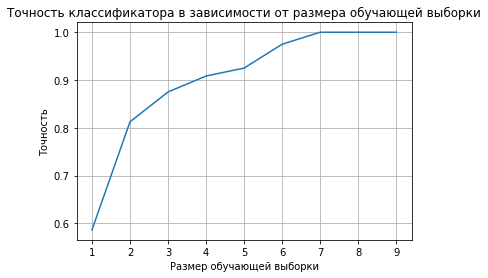

In [73]:
error_arr = np.zeros(opt_params_hist.shape)
for i, (size, param) in enumerate(zip(range(1,10), opt_params_hist)):
    classifier = Classifier(1, histogram, size, param)
    classifier.fit(path_to_train)
    pred, real = classifier.predict_all_test(path_to_test)
    error_arr[i] = count_error(pred, real)
fig, ax = plt.subplots()
ax.set_title('Точность классификатора в зависимости от размера обучающей выборки')
ax.plot(range(1,10), error_arr)
ax.grid()
ax.set_xlabel('Размер обучающей выборки')
ax.set_ylabel('Точность')
plt.show()

### DFT

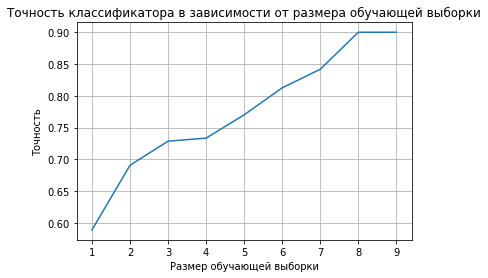

In [24]:
error_arr = np.zeros(opt_params_dft.shape)
for i, (size, param) in enumerate(zip(range(1,10), opt_params_dft)):
    classifier = Classifier(1, dft, size, param)
    classifier.fit(path_to_train)
    pred, real = classifier.predict_all_test(path_to_test)
    error_arr[i] = count_error(pred, real)
fig, ax = plt.subplots()
ax.set_title('Точность классификатора в зависимости от размера обучающей выборки')
ax.plot(range(1,10), error_arr)
ax.grid()
ax.set_xlabel('Размер обучающей выборки')
ax.set_ylabel('Точность')
plt.show()

### DCT

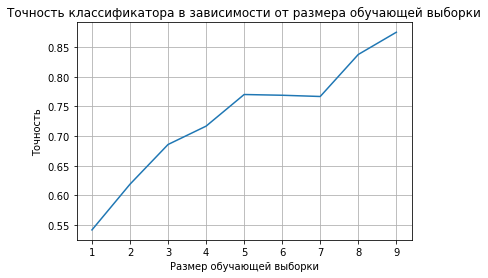

In [183]:
error_arr = np.zeros(opt_params_dct.shape)
for i, (size, param) in enumerate(zip(range(1,10), opt_params_dct)):
    classifier = Classifier(1, dct, size, param)
    classifier.fit(path_to_train)
    pred, real = classifier.predict_all_test(path_to_test)
    error_arr[i] = count_error(pred, real)
fig, ax = plt.subplots()
ax.set_title('Точность классификатора в зависимости от размера обучающей выборки')
ax.plot(range(1,10), error_arr)
ax.grid()
ax.set_xlabel('Размер обучающей выборки')
ax.set_ylabel('Точность')
plt.show()

### Scale

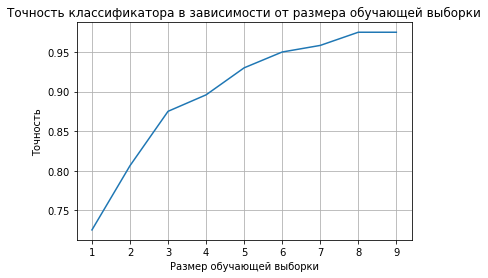

In [79]:
error_arr = np.zeros(opt_params_scale.shape)
for i, (size, param) in enumerate(zip(range(1,10), opt_params_scale)):
    classifier = Classifier(1, scale, size, param)
    classifier.fit(path_to_train)
    pred, real = classifier.predict_all_test(path_to_test)
    error_arr[i] = count_error(pred, real)
fig, ax = plt.subplots()
ax.set_title('Точность классификатора в зависимости от размера обучающей выборки')
ax.plot(range(1,10), error_arr)
ax.grid()
ax.set_xlabel('Размер обучающей выборки')
ax.set_ylabel('Точность')
plt.show()

### Градиент

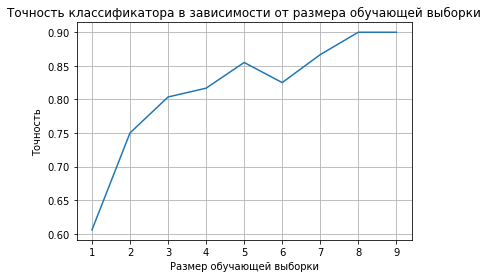

In [80]:
error_arr = np.zeros(opt_params_grad.shape)
for i, (size, param) in enumerate(zip(range(1,10), opt_params_grad)):
    classifier = Classifier(1, grad, size, param)
    classifier.fit(path_to_train)
    pred, real = classifier.predict_all_test(path_to_test)
    error_arr[i] = count_error(pred, real)
fig, ax = plt.subplots()
ax.set_title('Точность классификатора в зависимости от размера обучающей выборки')
ax.plot(range(1,10), error_arr)
ax.grid()
ax.set_xlabel('Размер обучающей выборки')
ax.set_ylabel('Точность')
plt.show()

# Прогноз для одного признака
С выводом близжайшего изображения

### Гистограмма

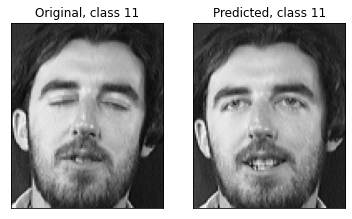

In [16]:
classifier_hist = Classifier(1, histogram, 8, 16)
classifier_hist.fit(path_to_train)
classifier_hist.draw_predict(path_to_test, 3, 9)
plt.show()

### DFT

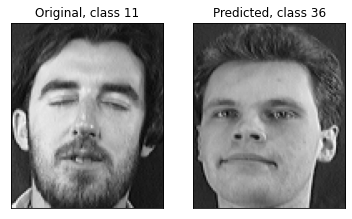

In [17]:
classifier_dft = Classifier(1, dft, 8, 16)
classifier_dft.fit(path_to_train)
classifier_dft.draw_predict(path_to_test, 3, 9)
plt.show()

### DCT

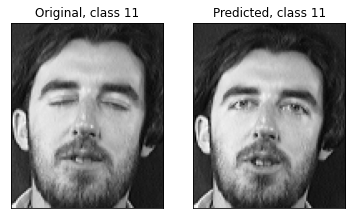

In [18]:
classifier_dct = Classifier(1, dct, 8, 16)
classifier_dct.fit(path_to_train)
classifier_dct.draw_predict(path_to_test, 3, 9)
plt.show()

### Scale

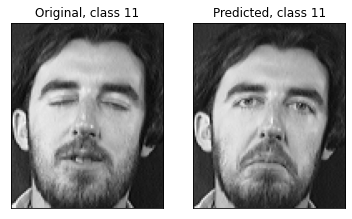

In [204]:
classifier_scale = Classifier(1, scale, 8, 16)
classifier_scale.fit(path_to_train)
classifier_scale.draw_predict(path_to_test, 3, 9)
plt.show()

### Градиент

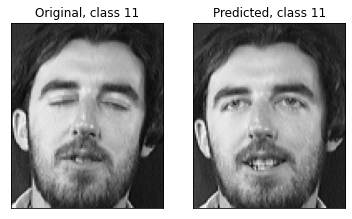

In [205]:
classifier_grad = Classifier(1, grad, 8, 16)
classifier_grad.fit(path_to_train)
classifier_grad.draw_predict(path_to_test, 3, 9)
plt.show()

# Маски

### Графики точности

#### Гистограмма

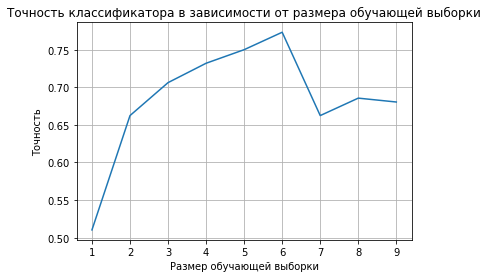

In [152]:
error_arr = np.zeros(opt_params_hist.shape)
for i, (size, param) in enumerate(zip(range(1,10), opt_params_hist)):
    classifier = Classifier(1, histogram, size, param)
    classifier.fit(path_to_train)
    pred, real = classifier.predict_all_test(path_to_test_masks, changed_db=True)
    error_arr[i] = count_error(pred, real)
fig, ax = plt.subplots()
ax.set_title('Точность классификатора в зависимости от размера обучающей выборки')
ax.plot(range(1,10), error_arr)
ax.grid()
ax.set_xlabel('Размер обучающей выборки')
ax.set_ylabel('Точность')
plt.show()

#### DFT

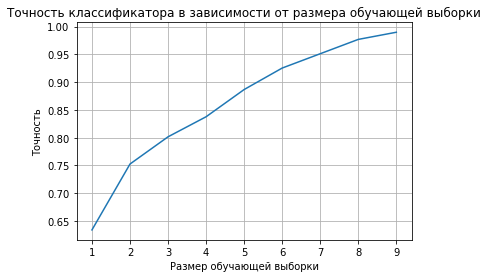

In [169]:
error_arr = np.zeros(opt_params_dft.shape)
for i, (size, param) in enumerate(zip(range(1,10), opt_params_dft)):
    classifier = Classifier(1, dft, size, param)
    classifier.fit(path_to_train)
    pred, real = classifier.predict_all_test(path_to_test_masks, changed_db=True)
    error_arr[i] = count_error(pred, real)
fig, ax = plt.subplots()
ax.set_title('Точность классификатора в зависимости от размера обучающей выборки')
ax.plot(range(1,10), error_arr)
ax.grid()
ax.set_xlabel('Размер обучающей выборки')
ax.set_ylabel('Точность')
plt.show()

#### DCT

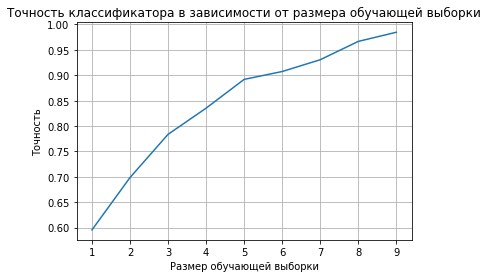

In [170]:
error_arr = np.zeros(opt_params_dct.shape)
for i, (size, param) in enumerate(zip(range(1,10), opt_params_dct)):
    classifier = Classifier(1, dct, size, param)
    classifier.fit(path_to_train)
    pred, real = classifier.predict_all_test(path_to_test_masks, changed_db=True)
    error_arr[i] = count_error(pred, real)
fig, ax = plt.subplots()
ax.set_title('Точность классификатора в зависимости от размера обучающей выборки')
ax.plot(range(1,10), error_arr)
ax.grid()
ax.set_xlabel('Размер обучающей выборки')
ax.set_ylabel('Точность')
plt.show()

#### Scale

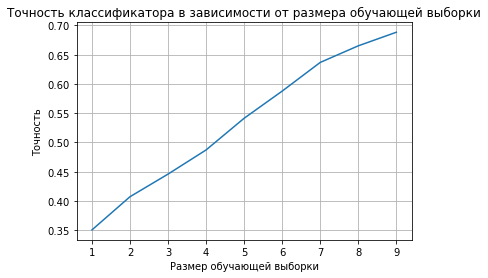

In [172]:
error_arr = np.zeros(opt_params_scale.shape)
for i, (size, param) in enumerate(zip(range(1,10), opt_params_scale)):
    classifier = Classifier(1, scale, size, param)
    classifier.fit(path_to_train)
    pred, real = classifier.predict_all_test(path_to_test_masks, changed_db=True)
    error_arr[i] = count_error(pred, real)
fig, ax = plt.subplots()
ax.set_title('Точность классификатора в зависимости от размера обучающей выборки')
ax.plot(range(1,10), error_arr)
ax.grid()
ax.set_xlabel('Размер обучающей выборки')
ax.set_ylabel('Точность')
plt.show()

#### Градиент

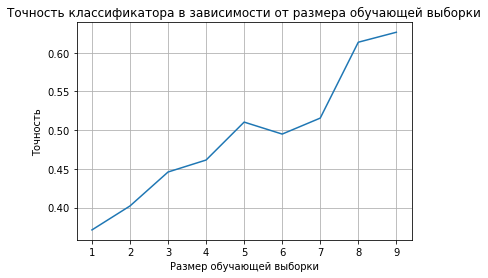

In [173]:
error_arr = np.zeros(opt_params_grad.shape)
for i, (size, param) in enumerate(zip(range(1,10), opt_params_grad)):
    classifier = Classifier(1, grad, size, param)
    classifier.fit(path_to_train)
    pred, real = classifier.predict_all_test(path_to_test_masks, changed_db=True)
    error_arr[i] = count_error(pred, real)
fig, ax = plt.subplots()
ax.set_title('Точность классификатора в зависимости от размера обучающей выборки')
ax.plot(range(1,10), error_arr)
ax.grid()
ax.set_xlabel('Размер обучающей выборки')
ax.set_ylabel('Точность')
plt.show()

### Примеры работы

#### Гистограмма

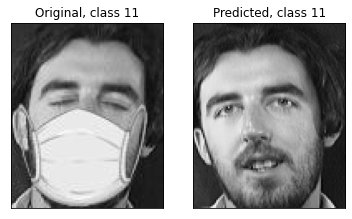

In [174]:
classifier_hist = Classifier(1, histogram, 8, 17)
classifier_hist.fit(path_to_train)
classifier_hist.draw_predict(path_to_test_masks, 3, 9, path_to_train)
plt.show()

#### DFT

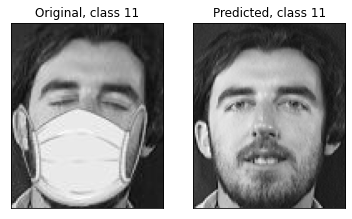

In [175]:
classifier_hist = Classifier(1, dft, 8, 33)
classifier_hist.fit(path_to_train)
classifier_hist.draw_predict(path_to_test_masks, 3, 9, path_to_train)
plt.show()

#### DCT

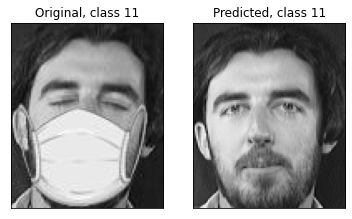

In [176]:
classifier_hist = Classifier(1, dct, 8, 27)
classifier_hist.fit(path_to_train)
classifier_hist.draw_predict(path_to_test_masks, 3, 9, path_to_train)
plt.show()

#### Scale

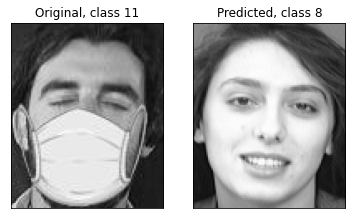

In [177]:
classifier_hist = Classifier(1, scale, 8, 22)
classifier_hist.fit(path_to_train)
classifier_hist.draw_predict(path_to_test_masks, 3, 9, path_to_train)
plt.show()

#### Градиент

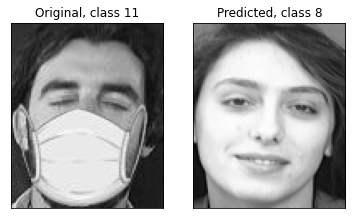

In [178]:
classifier_hist = Classifier(1, grad, 8, 5)
classifier_hist.fit(path_to_train)
classifier_hist.draw_predict(path_to_test_masks, 3, 9, path_to_train)
plt.show()

# Деиндентификация

## Графики точности

#### Гистограмма

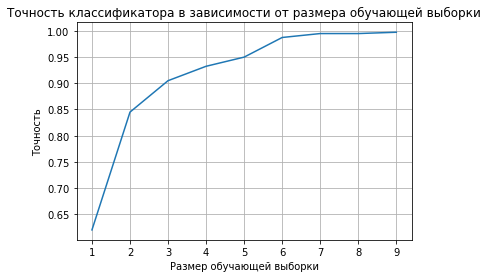

In [22]:
error_arr = np.zeros(opt_params_hist.shape)
for i, (size, param) in enumerate(zip(range(1,10), opt_params_hist)):
    classifier = Classifier(1, histogram, size, param)
    classifier.fit(path_to_train)
    pred, real = classifier.predict_all_test(path_to_test_deind, changed_db=True)
    error_arr[i] = count_error(pred, real)
fig, ax = plt.subplots()
ax.set_title('Точность классификатора в зависимости от размера обучающей выборки')
ax.plot(range(1,10), error_arr)
ax.grid()
ax.set_xlabel('Размер обучающей выборки')
ax.set_ylabel('Точность')
plt.show()

#### DFT

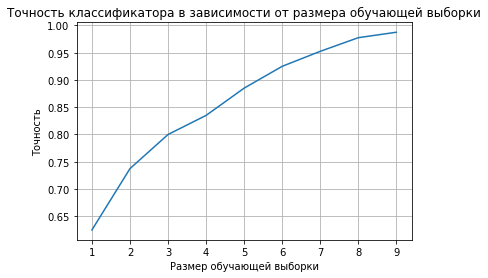

In [23]:
error_arr = np.zeros(opt_params_dft.shape)
for i, (size, param) in enumerate(zip(range(1,10), opt_params_dft)):
    classifier = Classifier(1, dft, size, param)
    classifier.fit(path_to_train)
    pred, real = classifier.predict_all_test(path_to_test_deind, changed_db=True)
    error_arr[i] = count_error(pred, real)
fig, ax = plt.subplots()
ax.set_title('Точность классификатора в зависимости от размера обучающей выборки')
ax.plot(range(1,10), error_arr)
ax.grid()
ax.set_xlabel('Размер обучающей выборки')
ax.set_ylabel('Точность')
plt.show()

#### DCT

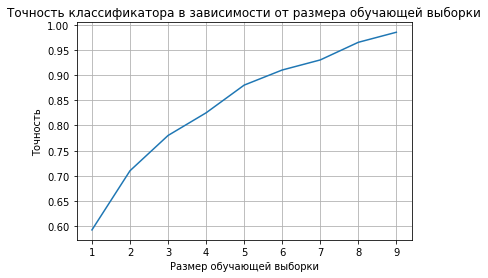

In [181]:
error_arr = np.zeros(opt_params_dct.shape)
for i, (size, param) in enumerate(zip(range(1,10), opt_params_dct)):
    classifier = Classifier(1, dct, size, param)
    classifier.fit(path_to_train)
    pred, real = classifier.predict_all_test(path_to_test_deind, changed_db=True)
    error_arr[i] = count_error(pred, real)
fig, ax = plt.subplots()
ax.set_title('Точность классификатора в зависимости от размера обучающей выборки')
ax.plot(range(1,10), error_arr)
ax.grid()
ax.set_xlabel('Размер обучающей выборки')
ax.set_ylabel('Точность')
plt.show()

#### Scale

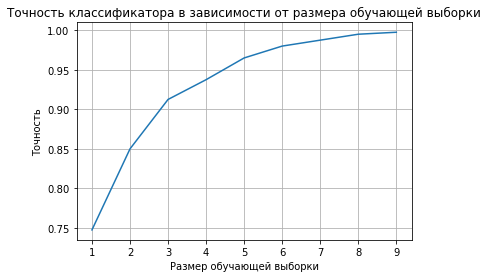

In [182]:
error_arr = np.zeros(opt_params_scale.shape)
for i, (size, param) in enumerate(zip(range(1,10), opt_params_scale)):
    classifier = Classifier(1, scale, size, param)
    classifier.fit(path_to_train)
    pred, real = classifier.predict_all_test(path_to_test_deind, changed_db=True)
    error_arr[i] = count_error(pred, real)
fig, ax = plt.subplots()
ax.set_title('Точность классификатора в зависимости от размера обучающей выборки')
ax.plot(range(1,10), error_arr)
ax.grid()
ax.set_xlabel('Размер обучающей выборки')
ax.set_ylabel('Точность')
plt.show()

#### Градиент

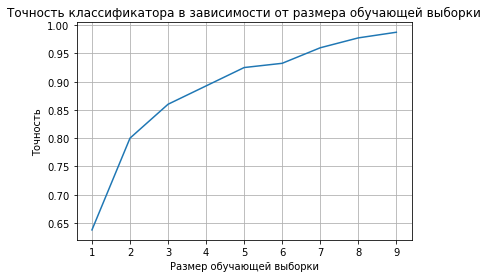

In [184]:
error_arr = np.zeros(opt_params_grad.shape)
for i, (size, param) in enumerate(zip(range(1,10), opt_params_grad)):
    classifier = Classifier(1, grad, size, param)
    classifier.fit(path_to_train)
    pred, real = classifier.predict_all_test(path_to_test_deind, changed_db=True)
    error_arr[i] = count_error(pred, real)
fig, ax = plt.subplots()
ax.set_title('Точность классификатора в зависимости от размера обучающей выборки')
ax.plot(range(1,10), error_arr)
ax.grid()
ax.set_xlabel('Размер обучающей выборки')
ax.set_ylabel('Точность')
plt.show()

## Пример работы

#### Гистограмма

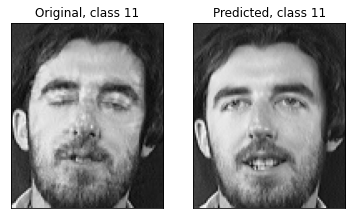

In [185]:
classifier_hist = Classifier(1, histogram, 8, 17)
classifier_hist.fit(path_to_train)
classifier_hist.draw_predict(path_to_test_deind, 3, 9, path_to_train)
plt.show()

#### DFT

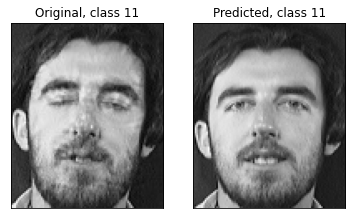

In [188]:
classifier_hist = Classifier(1, dft, 8, 33)
classifier_hist.fit(path_to_train)
classifier_hist.draw_predict(path_to_test_deind, 3, 9, path_to_train)
plt.show()

#### DCT

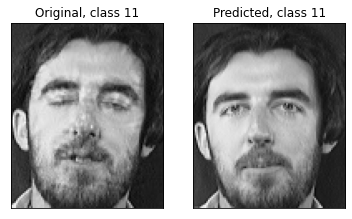

In [189]:
classifier_hist = Classifier(1, dct, 8, 27)
classifier_hist.fit(path_to_train)
classifier_hist.draw_predict(path_to_test_deind, 3, 9, path_to_train)
plt.show()

#### Scale

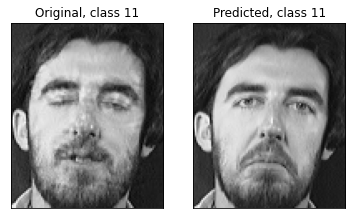

In [190]:
classifier_hist = Classifier(1, scale, 8, 22)
classifier_hist.fit(path_to_train)
classifier_hist.draw_predict(path_to_test_deind, 3, 9, path_to_train)
plt.show()

#### Градиент

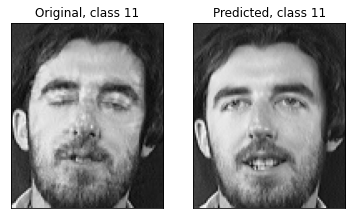

In [191]:
classifier_hist = Classifier(1, grad, 8, 5)
classifier_hist.fit(path_to_train)
classifier_hist.draw_predict(path_to_test_deind, 3, 9, path_to_train)
plt.show()

# Система голосования

In [20]:
class Vote:
    def __init__(self, num, hist_p, dft_p, dct_p, scale_p, grad_p):
        self.classifiers = []
        self.methods = (histogram, dft, dct, scale, grad)
        self.params = (hist_p, dft_p, dct_p, scale_p, grad_p)
        self.num = num
        self.classifiers.append(Classifier(1, histogram, num, hist_p))
        self.classifiers.append(Classifier(1, dft, num, dft_p))
        self.classifiers.append(Classifier(1, dct, num, dct_p))
        self.classifiers.append(Classifier(1, scale, num, scale_p))
        self.classifiers.append(Classifier(1, grad, num, grad_p))

    def fit(self, path_to_db):
        for classifier in self.classifiers:
            classifier.fit(path_to_db)

    def predict_all_test(self, path_to_db, changed_db=False, man_number=None):
        """
        predict_all_test(self, path_to_db, man_number=None)

        Предсказывает класс всех изображений из тестовых. Если задан man_number,
        то работает для конкретного класса, иначе для всех.
        """
        result_all = []
        pred_all = []
        for classifier in self.classifiers:
            pred, result_all = classifier.predict_all_test(path_to_db, changed_db=changed_db)
            pred_all.append(pred)
        pred_all = np.array(pred_all)
        # Выcчитывает предсказание
        pred_vote = np.array(list(map(lambda x: np.argmax(np.bincount(x)), [pred_all[:,j] for j in range(pred_all.shape[1])])))
        return pred_vote, result_all

    def return_pred_class(self, path_to_db, man, num_photo):
        """
        return_pred_class(self, path_to_db, man, num_photo)

        Возвращает спрогнозированный класс и исходный класс изображения.

        """
        pred_all = []
        for classifier in self.classifiers:
            pred, real = classifier.return_pred_class(path_to_db, man, num_photo)
            pred_all.append(pred)
        # Возвращает предсказанный класс
        pred_vote = np.argmax(np.bincount(pred_all))
        return pred_vote, real
        

    def draw_predict(self, path_to_db, man, num_photo, path_to_train=None):
        """
        draw_predict(self, path_to_db, man, num_photo)

        Возвращает исходное и спрогнозированное изображение.

        """
        dirs = os.listdir(path_to_db)
        X = []
        dir = dirs[man - 1]
        class_name = int(dir[1:])
        photos = os.listdir(os.path.join(path_to_db, dir))
        photo_name = photos[num_photo]
        path_photo = os.path.join(path_to_db, dir, photo_name)
        photo = cv.imread(path_photo, 0)

        plt.figure(figsize=(10,10), facecolor='white')
        plt.subplot(331)
        plt.title(f"Original, class {class_name}")
        plt.imshow(photo, cmap='gray')
        plt.xticks([])
        plt.yticks([])

        pred_hist = self.classifiers[0].return_pred_picture(path_to_db, man, num_photo, path_to_train)
        pred_hist_name,_ = self.classifiers[0].return_pred_class(path_to_db, man, num_photo)
        plt.subplot(332)
        plt.title(f"Гистограмма, class {pred_hist_name}")
        plt.xticks([])
        plt.yticks([])
        plt.imshow(pred_hist, cmap='gray')

        pred_dft = self.classifiers[1].return_pred_picture(path_to_db, man, num_photo, path_to_train)
        pred_dft_name,_ = self.classifiers[1].return_pred_class(path_to_db, man, num_photo)
        plt.subplot(333)
        plt.title(f"DFT, class {pred_dft_name}")
        plt.xticks([])
        plt.yticks([])
        plt.imshow(pred_dft, cmap='gray')

        pred_dct = self.classifiers[2].return_pred_picture(path_to_db, man, num_photo, path_to_train)
        pred_dct_name,_ = self.classifiers[2].return_pred_class(path_to_db, man, num_photo)
        plt.subplot(334)
        plt.title(f"DCT, class {pred_dct_name}")
        plt.xticks([])
        plt.yticks([])
        plt.imshow(pred_dct, cmap='gray')

        pred_scale = self.classifiers[3].return_pred_picture(path_to_db, man, num_photo, path_to_train)
        pred_scale_name,_ = self.classifiers[3].return_pred_class(path_to_db, man, num_photo)
        plt.subplot(335)
        plt.title(f"Scale, class {pred_scale_name}")
        plt.xticks([])
        plt.yticks([])
        plt.imshow(pred_scale, cmap='gray')

        pred_grad = self.classifiers[4].return_pred_picture(path_to_db, man, num_photo, path_to_train)
        pred_grad_name,_ = self.classifiers[4].return_pred_class(path_to_db, man, num_photo)
        plt.subplot(336)
        plt.title(f"Градиент, class {pred_grad_name}")
        plt.xticks([])
        plt.yticks([])
        plt.imshow(pred_grad, cmap='gray')

        vote_class, _ = self.return_pred_class(path_to_db, man, num_photo)
        dict_vote = {}
        
        for classifier in self.classifiers:
            result = classifier.return_pred_picture_info(path_to_db, man, num_photo, path_to_train)
            if dict_vote.get(result) is None:
                dict_vote[result] = 1
            else:
                dict_vote[result] += 1
        max_class_name = None
        max_pic_name = None
        max_number = 0
        for (class_name, picture_name), number in dict_vote.items():
            if int(class_name[1:]) == vote_class:
                if max_number == 0 or max_number < number:
                    max_number = number
                    max_class_name = class_name
                    max_pic_name = picture_name
        
        path_to_train = path_to_db if path_to_train is None else path_to_train
        vote_picture_path = os.path.join(path_to_train, max_class_name, max_pic_name)
        vote_picture = cv.imread(vote_picture_path, 0)
        plt.subplot(338)
        plt.title(f"Голосование, class {vote_class}")
        plt.xticks([])
        plt.yticks([])
        plt.imshow(vote_picture, cmap='gray')


        

# Точность системы голосования

In [140]:
opt_params_hist = np.array([27, 27, 28, 27, 27, 23, 17, 17, 17])
opt_params_dft = np.array([35, 35, 35, 35, 32, 32, 32, 33, 30])
opt_params_dct = np.array([30, 30, 28, 28, 28, 27, 27, 27, 27])
opt_params_scale = np.array([22, 22, 24, 24, 24, 22, 25, 22, 22])
opt_params_grad = np.array([8, 7, 6, 6, 6, 6, 7, 5, 5])

## Обычная

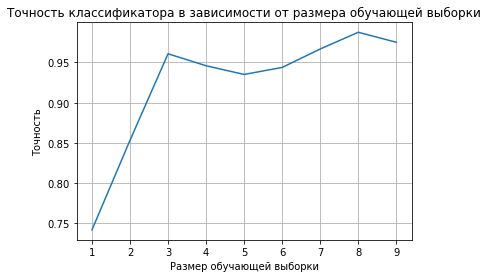

In [229]:
error_arr = np.zeros(opt_params_hist.shape)
for i, size in enumerate(range(1,10)):
    vote = Vote(size,opt_params_hist[i], opt_params_dft[i], opt_params_dct[i], opt_params_scale[i], opt_params_grad[i])
    vote.fit(path_to_train)
    pred, real = vote.predict_all_test(path_to_test)
    error_arr[i] = count_error(pred, real)
fig, ax = plt.subplots()
ax.set_title('Точность классификатора в зависимости от размера обучающей выборки')
ax.plot(range(1,10), error_arr)
ax.grid()
ax.set_xlabel('Размер обучающей выборки')
ax.set_ylabel('Точность')
plt.show()

In [142]:
vote = Vote(8, 17, 33, 27, 22, 5)
vote.fit(path_to_test)
pred, real = vote.predict_all_test(path_to_test)
print(count_error(pred, real))

0.9875


## Маски

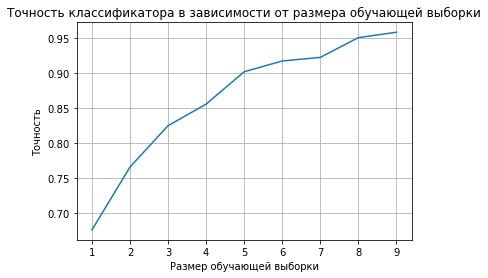

In [230]:
error_arr = np.zeros(opt_params_hist.shape)
for i, size in enumerate(range(1,10)):
    vote = Vote(size,opt_params_hist[i], opt_params_dft[i], opt_params_dct[i], opt_params_scale[i], opt_params_grad[i])
    vote.fit(path_to_train)
    pred, real = vote.predict_all_test(path_to_test_masks, changed_db=True)
    error_arr[i] = count_error(pred, real)
fig, ax = plt.subplots()
ax.set_title('Точность классификатора в зависимости от размера обучающей выборки')
ax.plot(range(1,10), error_arr)
ax.grid()
ax.set_xlabel('Размер обучающей выборки')
ax.set_ylabel('Точность')
plt.show()

In [233]:
vote = Vote(9, 17, 30, 27, 22, 5)
vote.fit(path_to_train)
pred, real = vote.predict_all_test(path_to_test_masks, changed_db=True)
print(count_error(pred, real))

0.9587628865979382


## Деидентификация

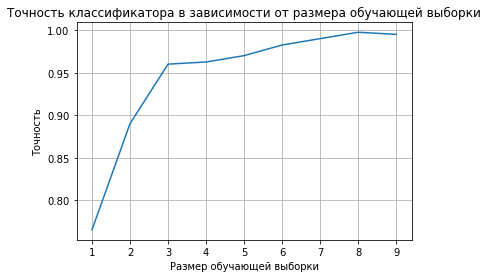

In [234]:
error_arr = np.zeros(opt_params_hist.shape)
for i, size in enumerate(range(1,10)):
    vote = Vote(size,opt_params_hist[i], opt_params_dft[i], opt_params_dct[i], opt_params_scale[i], opt_params_grad[i])
    vote.fit(path_to_train)
    pred, real = vote.predict_all_test(path_to_test_deind, changed_db=True)
    error_arr[i] = count_error(pred, real)
fig, ax = plt.subplots()
ax.set_title('Точность классификатора в зависимости от размера обучающей выборки')
ax.plot(range(1,10), error_arr)
ax.grid()
ax.set_xlabel('Размер обучающей выборки')
ax.set_ylabel('Точность')
plt.show()

In [236]:
vote = Vote(8, 17, 33, 27, 22, 5)
vote.fit(path_to_train)
pred, real = vote.predict_all_test(path_to_test_deind, changed_db=True)
print(count_error(pred, real))

0.9975


# Пример работы системы голосования

#### Обычная

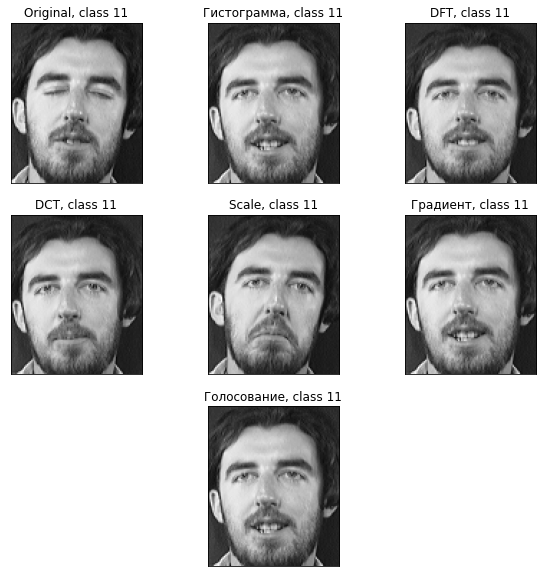

In [21]:
vote = Vote(8, 17, 33, 27, 22, 5)
vote.fit(path_to_test)
vote.draw_predict(path_to_test, 3, 9)
plt.show()

#### Маски

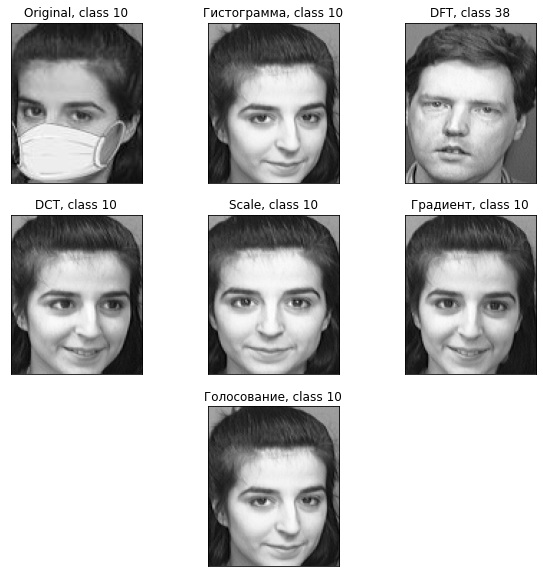

In [238]:
vote = Vote(8, 17, 33, 27, 22, 5)
vote.fit(path_to_test)
vote.draw_predict(path_to_test_masks, 2, 9, path_to_train)
plt.show()

#### Деиндентификация

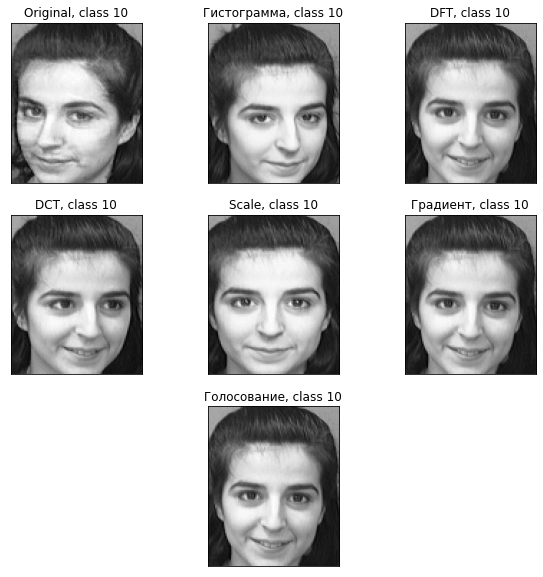

In [225]:
vote = Vote(8, 17, 33, 27, 22, 5)
vote.fit(path_to_test)
vote.draw_predict(path_to_test_deind, 2, 9, path_to_train)
plt.show()